In [42]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

In [43]:
from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho

In [44]:
import cosima_cookbook as cc

In [45]:
session = cc.database.create_session()

In [46]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,01deg_jra55v13_ryf9091_OFAM3visc,50
1,01deg_jra55v13_ryf9091_tides_fixed,1823
2,01deg_jra55v13_ryf9091_k_smag_iso3,128
3,01deg_jra55v13_ryf9091_5Kv,102
4,1deg_jra55v131_ryf_nonuniform_albedo,260
5,01deg_jra55v13_ryf9091_tides_control,620
6,1deg_jra55v131_ryf_const_albedo,260
7,01deg_jra55v13_ryf9091_tides,2578
8,025deg_jra55_ryf9091_gadi_noGM,316
9,1deg_jra55_iaf_v2.0.0rc3_nonuniform_albedo,4660


In [74]:
expt = '01deg_jra55v13_ryf9091'
vars_01deg = cc.querying.get_variables(session, experiment='01deg_jra55v13_ryf9091')
vars_01deg[vars_01deg['name'].str.lower().str.match('time')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
66,time,None,None,output888/ocean/o2i.nc,1017,None,None
96,time,time,1 daily,output888/ocean/ocean_daily.nc,3265,1950-01-01 00:00:00,2123-04-01 00:00:00
97,time_bounds,time axis boundaries,1 daily,output888/ocean/ocean_daily.nc,3265,1950-01-01 00:00:00,2123-04-01 00:00:00
232,time,time,1 monthly,output888/ocean/ocean_scalar.nc,5325,1900-01-01 00:00:00,2123-04-01 00:00:00
233,time_bounds,time axis boundaries,1 monthly,output888/ocean/ocean_scalar.nc,5325,1900-01-01 00:00:00,2123-04-01 00:00:00
315,time,time,3 monthly,output195/ocean/ocean.nc,196,1900-01-01 00:00:00,1950-01-01 00:00:00
316,time_bounds,time axis boundaries,3 monthly,output195/ocean/ocean.nc,196,1900-01-01 00:00:00,1950-01-01 00:00:00
347,time,time,static,output888/ocean/ocean_grid.nc,889,1900-04-01 00:00:00,2123-04-01 00:00:00


In [59]:
#Input all data needed from the model for tenth degree
x_u = cc.querying.getvar(expt,'xu_ocean',session,n=1).sel(xu_ocean=slice(-90,10))
x_t = cc.querying.getvar(expt,'xt_ocean',session,n=1).sel(xt_ocean=slice(-90,10))
y_u = cc.querying.getvar(expt,'yu_ocean',session,n=1).sel(yu_ocean=slice(0,70))
y_t = cc.querying.getvar(expt,'yt_ocean',session,n=1).sel(yt_ocean=slice(0,70))
z_t = cc.querying.getvar(expt,'st_ocean',session,n=1)
salt = cc.querying.getvar(expt,'salt',session,start_time='1990-01-01',end_time='2000-12-31').sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(0,70)).sel(st_ocean = 1, method = 'nearest')
T = cc.querying.getvar(expt,'temp',session,start_time='1990-01-01',end_time='2000-12-31').sel(
    xt_ocean=slice(-90,10)).sel(yt_ocean=slice(0,70)).sel(st_ocean = 1, method = 'nearest')

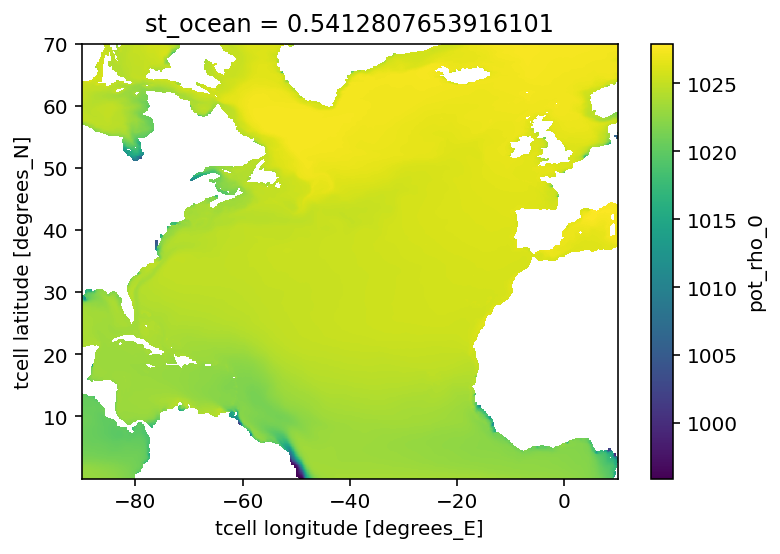

In [50]:
expt = '01deg_jra55v13_ryf9091'
variable = 'pot_rho_0'
potrho = cc.querying.getvar(expt,variable,session,start_time='1990-01-01',end_time='2000-12-31').sel(
                           yt_ocean=slice(0,70)).sel(xt_ocean=slice(-90,10)).sel(st_ocean = 1,method = 'nearest')
potrho.mean('time').plot()

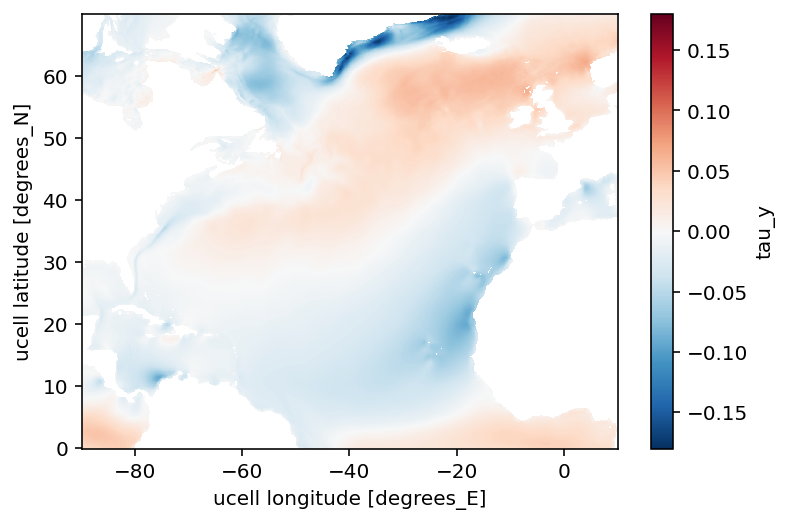

In [56]:
expt = '01deg_jra55v13_ryf9091'
variable = 'tau_x'
tau_x = cc.querying.getvar(expt,variable,session,start_time='1990-01-01',end_time='2000-12-31').sel(
    yu_ocean=slice(0,70)).sel(xu_ocean=slice(-90,10))
variable = 'tau_y'
tau_y = cc.querying.getvar(expt,variable,session,start_time='1990-01-01',end_time='2000-12-31').sel(
    yu_ocean=slice(0,70)).sel(xu_ocean=slice(-90,10))
tau_y.mean('time').plot()

In [75]:
# Converting Dataset into Dataarray
time = cc.querying.getvar(expt,'time',session,start_time='1990-01-01',end_time='2000-12-31')
tau_x_Array = xr.DataArray(tau_x, coords = [y_u, x_u, time],  dims = ['yu_ocean', 'xu_ocean','time'], 
                         name = 'x Direction Ekman Transport', attrs = {'units':'m^2/s'})
tau_y_Array = xr.DataArray(tau_y, coords = [y_u, x_u, time],  dims = ['yu_ocean', 'xu_ocean','time'], 
                         name = 'y Direction Ekman Transport', attrs = {'units':'m^2/s'})

KeyboardInterrupt: 

In [76]:
tau_x

,Array,Chunk
Bytes,530.28 MB,2.16 MB
Shape,"(135, 982, 1000)","(1, 675, 800)"
Count,6795 Tasks,810 Chunks
Type,float32,numpy.ndarray


## Calculating the Ekman Layer Depth

In [58]:
tau_y

,Array,Chunk
Bytes,530.28 MB,2.16 MB
Shape,"(135, 982, 1000)","(1, 675, 800)"
Count,6795 Tasks,810 Chunks
Type,float32,numpy.ndarray


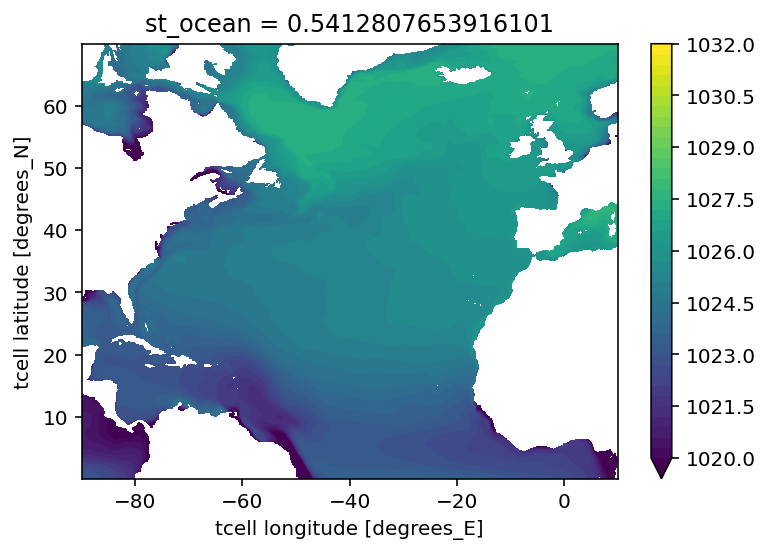

In [65]:
Y,Z,X =  np.meshgrid(y_t,z_t,x_t)
pressure_array = xr.DataArray(p_from_z(-Z,Y),  coords = [z_t, y_t, x_t],  
                              dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
pressure_array_NA = pressure_array.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(0,70)).sel(st_ocean = 1,method = 'nearest')
rho_mat = rho(salt,T-273.15,pressure_array_NA)

rho_mat.mean('time').plot.contourf(levels = np.linspace(1020,1032,41))

In [66]:
rho_mat

,Array,Chunk
Bytes,1.06 GB,960.00 kB
Shape,"(135, 982, 1000)","(1, 300, 400)"
Count,644343 Tasks,2160 Chunks
Type,float64,numpy.ndarray


In [77]:
import xgcm

tau_x = tau_x.rename('Wind stress in x direction')
tau_y = tau_y.rename('Wind stress in y direction')
paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091_gadi_retest/output328/ocean/ocean.nc")
data = xr.merge((tau_x,tau_y,T))
data.coords['xt_ocean'].attrs.update(axis='X')
data.coords['xu_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yt_ocean'].attrs.update(axis='Y')
data.coords['yu_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)
data.coords['st_ocean'].attrs.update(axis='Z')

g = xgcm.Grid(data, periodic=['X'])
tempo = g.interp(tau_x,'X')
tau_x_interp = g.interp(tempo,'Y',boundary="extend")

g = xgcm.Grid(data, periodic=['Y'])
tempo = g.interp(tau_y,'Y')
tau_y_interp = g.interp(tempo,'X',boundary="extend")

In [68]:
r0 = 6.371 * 10**6
Gradx_potrho = potrho.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((potrho.yt_ocean*np.pi)/180))
Grady_potrho = potrho.differentiate('yt_ocean')*(180/np.pi)/r0

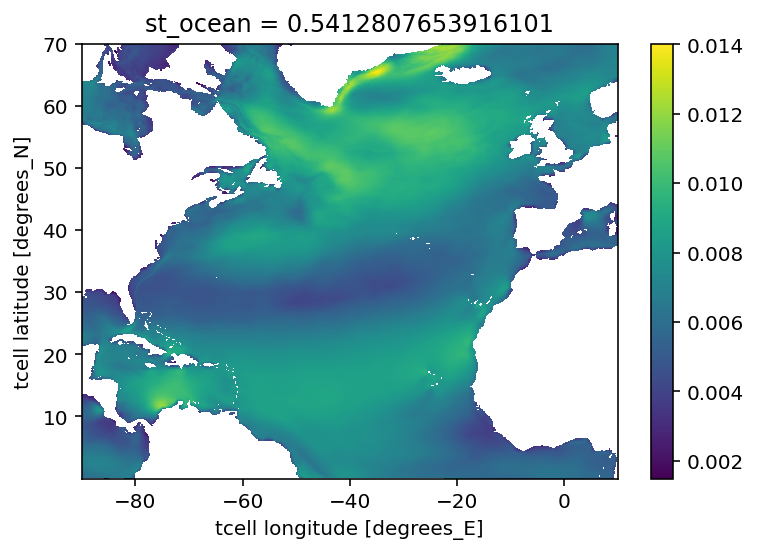

In [96]:
taumag = (tau_x_interp**2 + tau_y_interp**2)**0.5
abs_tau = abs(taumag)
ustar = (abs_tau/rho_mat)**0.5
ustar.mean('time').plot()

In [98]:
#Finding Coriolis Parameter
av = 7.2921159 * 10**(-5)
r0 = 6.371 * 10**6
rho_0 = 1026
f = 2*av*np.sin((tau_x_interp.yt_ocean*np.pi)/180)  #Coriolis Parameter
MLD = 0.4*(ustar/f)
Jzw = (tau_x_interp*Gradx_potrho - tau_y_interp*Grady_potrho)/(rho_0*MLD)

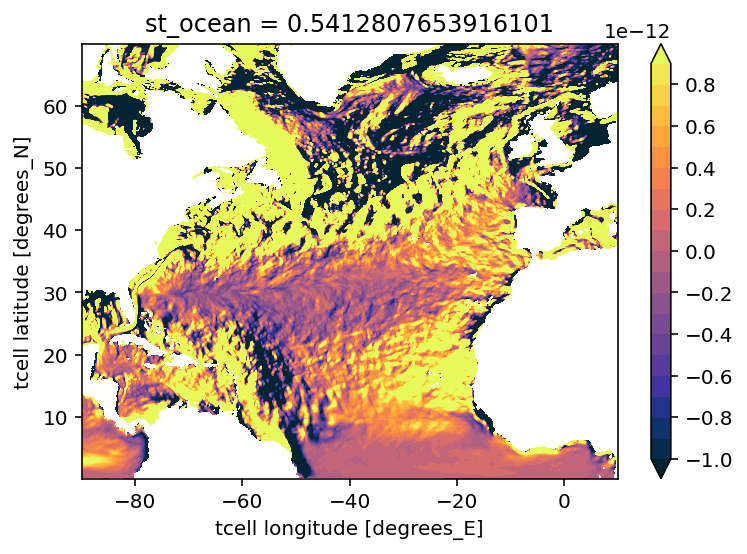

In [41]:
Jzw.plot.contourf(levels=np.arange(-1e-12,1e-12,1e-13), cmap=cm.cm.thermal);

In [99]:
Jzw

,Array,Chunk
Bytes,1.06 GB,960.00 kB
Shape,"(135, 982, 1000)","(1, 300, 400)"
Count,1279006 Tasks,8505 Chunks
Type,float64,numpy.ndarray
